In [63]:
from sklearn.model_selection import cross_val_score
import pickle
# ^^^ pyforest auto-imports - don't write above this line
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder


#modeles :
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, auc


import time

from termcolor import colored
import os
import warnings
warnings.filterwarnings('ignore')

In [47]:
path_train = r"D:\Etude_Data_science\Kaggle_competition\08_Binary_Classification_of_Insurance_Cross_Selling\dataset\train.csv"

# Plan :

## 1. Préparation des données : utilisation du stratify
- 1.2 Préparation des fonctions de modélisation
- 1.3 Modélisation
- 1.4 Résultats

## 2. Préparation des données : Equilibrage de la target 50/50 manuellement
- 2.1 Modélisation
- 2.2 Résultats

- Le jeu de données contient 10^7 observation, ce nombre augmentera de façons conséquentes le temps d'entrainement de chacun des modèles.
- Pour eviter cela, nous allons **travailler avec des échantillons**

### 1. Préparation des données : utilisation du stratify
#### 1.2 Préparation des fonctions de modélisation


In [122]:
data = pd.read_csv("df_preprocessed", index_col=0)

In [49]:
# df = data.copy()
df = data.copy().sample(10000, random_state=42)

In [50]:
print(df.shape)
df.head()

(10000, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
7190461,7190461,1.0,-0.559322,1,46.0,1,1.0,0.0,-1.713335,0.880671,1.676972,0
8449477,8449477,0.0,-1.092898,1,25.0,1,1.0,0.0,-0.150169,0.732644,1.039291,0
2200792,2200792,1.0,-0.692716,1,11.0,1,1.0,0.0,-0.256240,0.732644,-0.573665,0
8480431,8480431,0.0,2.442042,1,28.0,0,0.0,1.0,0.534860,0.825161,0.714199,0
3153076,3153076,1.0,0.174345,1,36.0,0,0.0,1.0,-1.713335,0.806658,-1.173835,0


In [51]:
X = df.drop("Response",axis=1)
y = df["Response"]
X_train,X_test,y_train,y_test = train_test_split(X,y, stratify=y, test_size=0.2, random_state=42)

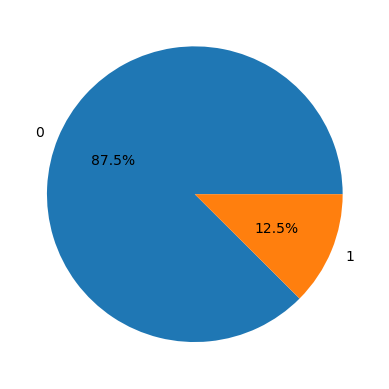

In [52]:
prop_targ = df.Response.value_counts(normalize=True)
plt.pie(prop_targ.values, labels=prop_targ.keys(), autopct='%1.1f%%' )
plt.show()

- Nous voyons ici les proportions de la target totalement desequilibré

In [53]:
def train(model):
    """Fonction qui entraine un modèle et affiche le score obtenu sur 5 splits après
    cross validation et le score moyen. 
    Renvoi un tuple de trois éléments :
    (predictions, temps d'execution, le modèle entrainé)"""
    
    scores = cross_val_score(estimator=model, X=X_train.values, y=y_train)
    
    start_time = time.time()
    
    model.fit(X_train,y_train)
    
    end_time = time.time()
    
    # durée totale de l'entrainement 
    training_time = round(end_time - start_time,2)
    
    # Durée en minute :
    training_time_min = round(training_time/60,2)

    yp = model.predict(X_test.values)
    
    print(colored(type(model).__name__,"light_green",attrs=["bold"]))
    print("Scores sur 5 splits : ", [i.round(3) for i in scores])
    print("Score moyen :", scores.mean().round(3))

    return (yp, training_time_min, model)

def metric(prediction, model_name):
    """Fonction qui renvoie un objet pandas Series contenant les valeurs des metrics
    principales : f1 score, accuracy, recall, precision score à partir de la liste des prédictions d'un modèle"""
    
    f1 = metrics.f1_score(y_true = y_test, y_pred = prediction, average='weighted')
    accuracy = metrics.accuracy_score(y_true = y_test, y_pred = prediction)
    recal = metrics.recall_score(y_true = y_test, y_pred = prediction, average='weighted')
    precision = metrics.precision_score(y_true = y_test, y_pred = prediction, average='weighted')
    
    all_metric = [f1,accuracy,recal,precision]
    
    index_metric = ["F1-score","Accuracy","Recall","Precision"]
    
    series = pd.Series(all_metric, name=str(model_name), index=index_metric)
    return pd.DataFrame(series)

def trainig_series(list_models):
    """Fonction qui entraine en série plusieurs modèle à la fois
    Renvoie un tuple contenant 4 éléments :
    DataFrame contenant toutes les métrics
    DataFrame contenant toutes les prédictions de modèles
    Dictionnaire contenant tout les modèles préentrainés
    Dictionnaire contenant le temps d'entrainement de chaque modèle
    """
    #Dictionnaire qui contiendra les différentes metrics de chaque modèle
    dict_metric = {}
    #dictionnaire contenant les valeurs prédictives pour chaque modèles
    dict_prediction = {}
    #dictionnaire contenant les modele entrainé
    dict_model_trained = {}
    #dictionnaire contenant le temps d'exécution 
    dict_time ={}
        
    
    for current_model in list_models:
        #Recuperation des prédictions et du temps d'execution de chaque modèles
        prediction, temps_exe, model_trained = train(current_model)

        # Récupération du nom du modèle et du chemin d'enregistrement
        model_name = type(current_model).__name__

        # Enregitrement des modèles après entrainement : 
        dict_model_trained[model_name] = model_trained

        #Enregistrement des prédiction dans le dictionnaire :
        dict_prediction[model_name] = prediction

        # Enregistrement des métriques au dictionnaire
        dict_metric[model_name] = metric(prediction=prediction, model_name=model_name)
        
        #Enregistrement du tps d'execution
        dict_time[model_name] = temps_exe  
        
    #Pour les Dataframe :    
    # Concaténation des métriques en un DataFrame et inversion des colonnes et index :
    df_metrics = pd.concat(dict_metric.values(), axis=1).T 
    #Enregistrement des prédictions dans un dataframe :
    df_prediction = pd.DataFrame(dict_prediction)
    
    return (df_metrics,df_prediction,dict_model_trained, dict_time)

def enregistrement_model(pretrained_models):
    """Prend en entrée un dictionnaire sous forme {nom_modèle : modèle préentrainé}"""
    for i in pretrained_models:
        model_name = i
        current_model = pretrained_models[model_name]
        model_filename = os.path.join(f"{model_name}.pkl")
        #Enregistrement des modèles préentrainé :
        with open(model_filename, 'wb') as model_file:
            pickle.dump(current_model, model_file)
        print(f'{colored(model_name,"blue")} enregistré sous {colored(model_filename,"green")}')

In [54]:
 #visualisation du temp d'entrainement
def graph_time(dictionnary_time):
    """Fonction qui récupère un dictionnaire contenant les informations sur la durée d'entrainement des modèles et renvoie un barplot"""
    df_time = pd.DataFrame.from_dict(dictionnary_time, orient = "index", columns=["Duree d'entrainement"])
    plt.figure(figsize=(16,4))
    plt.grid()
    ax = sns.barplot(x = df_time.index, y = df_time.columns[0], data = df_time)
    ax.set_xticklabels(labels = df_time.index, rotation = 45)
    plt.xlabel("Modèles")
    plt.title("Durée d'entrainement des différents modèles (en minutes)")
    plt.show()

    
#Visualisation des metrics avec un barplot
def metric_plot(df_metric):
    mesure_reset = df_metric.reset_index()
    # Ensuite, ON utilise melt avec le nouvel index comme id_vars
    metric_df_melt = mesure_reset.melt(id_vars="index", var_name="Model", value_name="Score")

    plt.figure(figsize=(16,6))
    plt.grid()
    sns.barplot(data=metric_df_melt, x="index", y="Score", hue="Model")
    plt.legend(bbox_to_anchor=(1,1))
    plt.title('Comparaison des scores des modèles')
    plt.show()
    

In [73]:
def matrice(pred, nrow, ncol):
    plt.figure(figsize=(14, 14))  
    for i, col in enumerate(pred, 1):
        cf = metrics.confusion_matrix(y_true=y_test, y_pred=pred[col])
        ax = plt.subplot(nrow, ncol, i)
        sns.heatmap(cf, annot=True, ax=ax,linewidths=0.8, linecolor="black",fmt=".0f", cbar=False, cmap="Blues")
        ax.set_xlabel('Prédictions')
        ax.set_ylabel('Valeurs réelles')
        ax.set_title(f"{col}")
    plt.tight_layout()  # Pour éviter les chevauchements
    plt.show()

def ROC(model_list, X_test, y_test, nrow, ncol):
    """Fonction pour obtenir la courbe ROC pour plusieurs modèles de classification binaire"""
    plt.figure(figsize=(15, 10))

    # Boucle sur chaque modèle et on trace la courbe ROC dans un sous-graphique
    for i, model in enumerate(model_list):
        plt.subplot(nrow, ncol, i + 1)  # i+1 parce que subplot commence à 1

        # Prédiction des probabilités pour le modèle courant
        predicted_probabilities = model_list[model].predict(X_test)

        # Calcul de la courbe ROC et de l'AUC
        fpr, tpr, _ = roc_curve(y_test, predicted_probabilities)
        roc_auc = auc(fpr, tpr)

        # Tracé de la courbe ROC
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        
        # Ligne en pointillés représentant la performance aléatoire
        plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Aléatoire')
        
        # Ajout des légendes et des titres
        plt.legend(loc="lower right")
        plt.xlabel('Taux de faux positifs (FPR)')
        plt.ylabel('Taux de vrais positifs (TPR)')
        plt.title(f'Courbe ROC - {model}')
        plt.grid()

    plt.tight_layout()  
    plt.show()


#### 1.3 Modélisation


In [56]:
##### Liste des modèles utilisés :
all_model = [
    DummyClassifier(strategy="most_frequent"),
    LogisticRegression(),
    KNeighborsClassifier(),
    SGDClassifier(loss="modified_huber"), 
    RandomForestClassifier(),
    AdaBoostClassifier(),
    XGBClassifier()
            ]

#Remarque : loss = "modified_huber" SGDC,cela permet d'utiliser le "predict_proba(X_test.values)"
# c'est indispensable à notre fonction ROC (car on utilise predict_proba et label_binarizer)
#sinon cela ne fonctionne pas car la courbe ROC n'est pas adapté aux problèmes non binaires

In [57]:
#Entrainement en série :
mesure, prediction,model_entraine, exe_time = trainig_series(all_model)

DummyClassifier
Scores sur 5 splits :  [0.876, 0.876, 0.875, 0.875, 0.875]
Score moyen : 0.875
LogisticRegression
Scores sur 5 splits :  [0.876, 0.876, 0.875, 0.875, 0.875]
Score moyen : 0.875
KNeighborsClassifier
Scores sur 5 splits :  [0.869, 0.861, 0.863, 0.862, 0.867]
Score moyen : 0.864
SGDClassifier
Scores sur 5 splits :  [0.876, 0.876, 0.875, 0.875, 0.875]
Score moyen : 0.875
RandomForestClassifier
Scores sur 5 splits :  [0.868, 0.872, 0.874, 0.869, 0.864]
Score moyen : 0.869
AdaBoostClassifier
Scores sur 5 splits :  [0.871, 0.874, 0.874, 0.87, 0.876]
Score moyen : 0.873
XGBClassifier
Scores sur 5 splits :  [0.866, 0.866, 0.868, 0.859, 0.852]
Score moyen : 0.862


In [58]:
#Sauvegarde des modèles préentrainé :
enregistrement_model(model_entraine)

DummyClassifier enregistré sous DummyClassifier.pkl
LogisticRegression enregistré sous LogisticRegression.pkl
KNeighborsClassifier enregistré sous KNeighborsClassifier.pkl
SGDClassifier enregistré sous SGDClassifier.pkl
RandomForestClassifier enregistré sous RandomForestClassifier.pkl
AdaBoostClassifier enregistré sous AdaBoostClassifier.pkl
XGBClassifier enregistré sous XGBClassifier.pkl


#### 1.4 Résultats


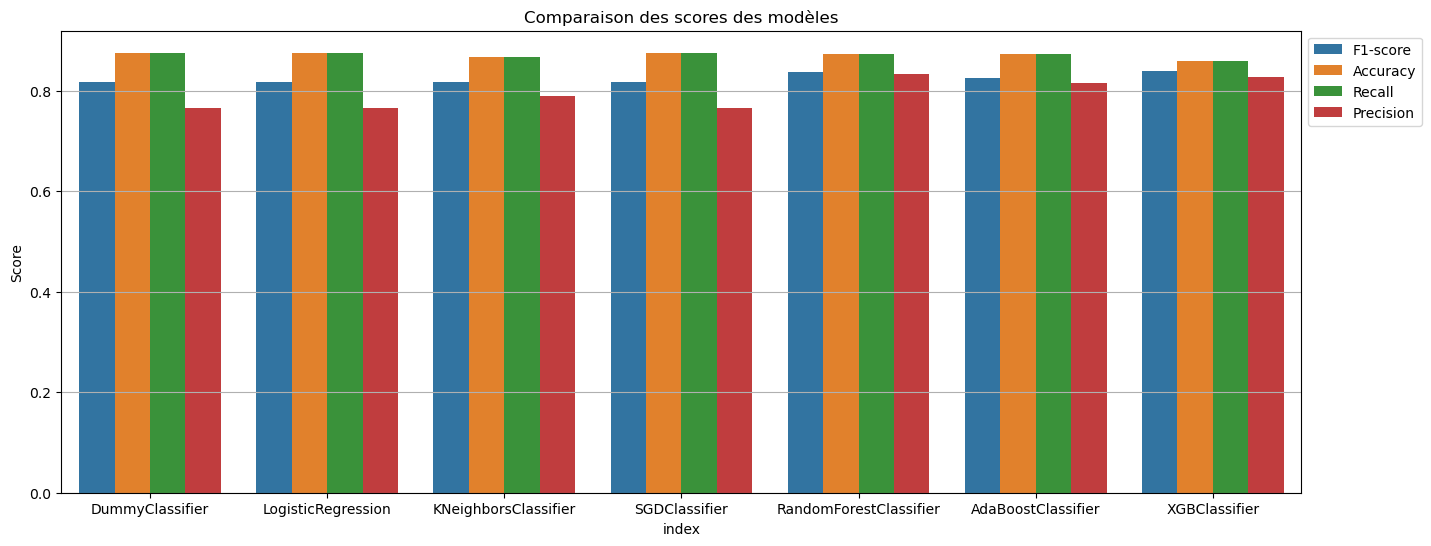

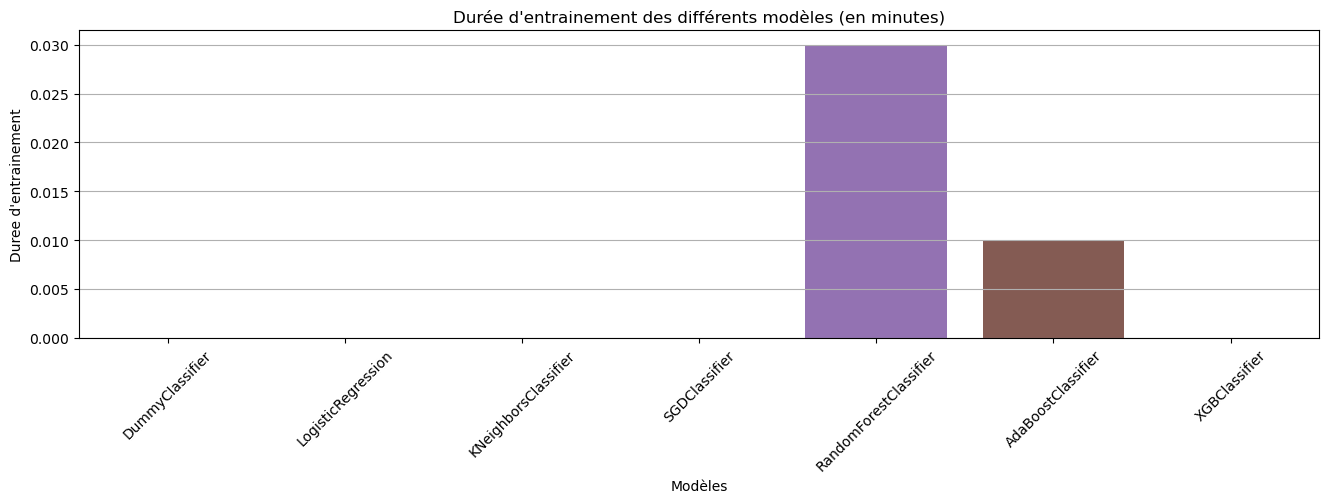

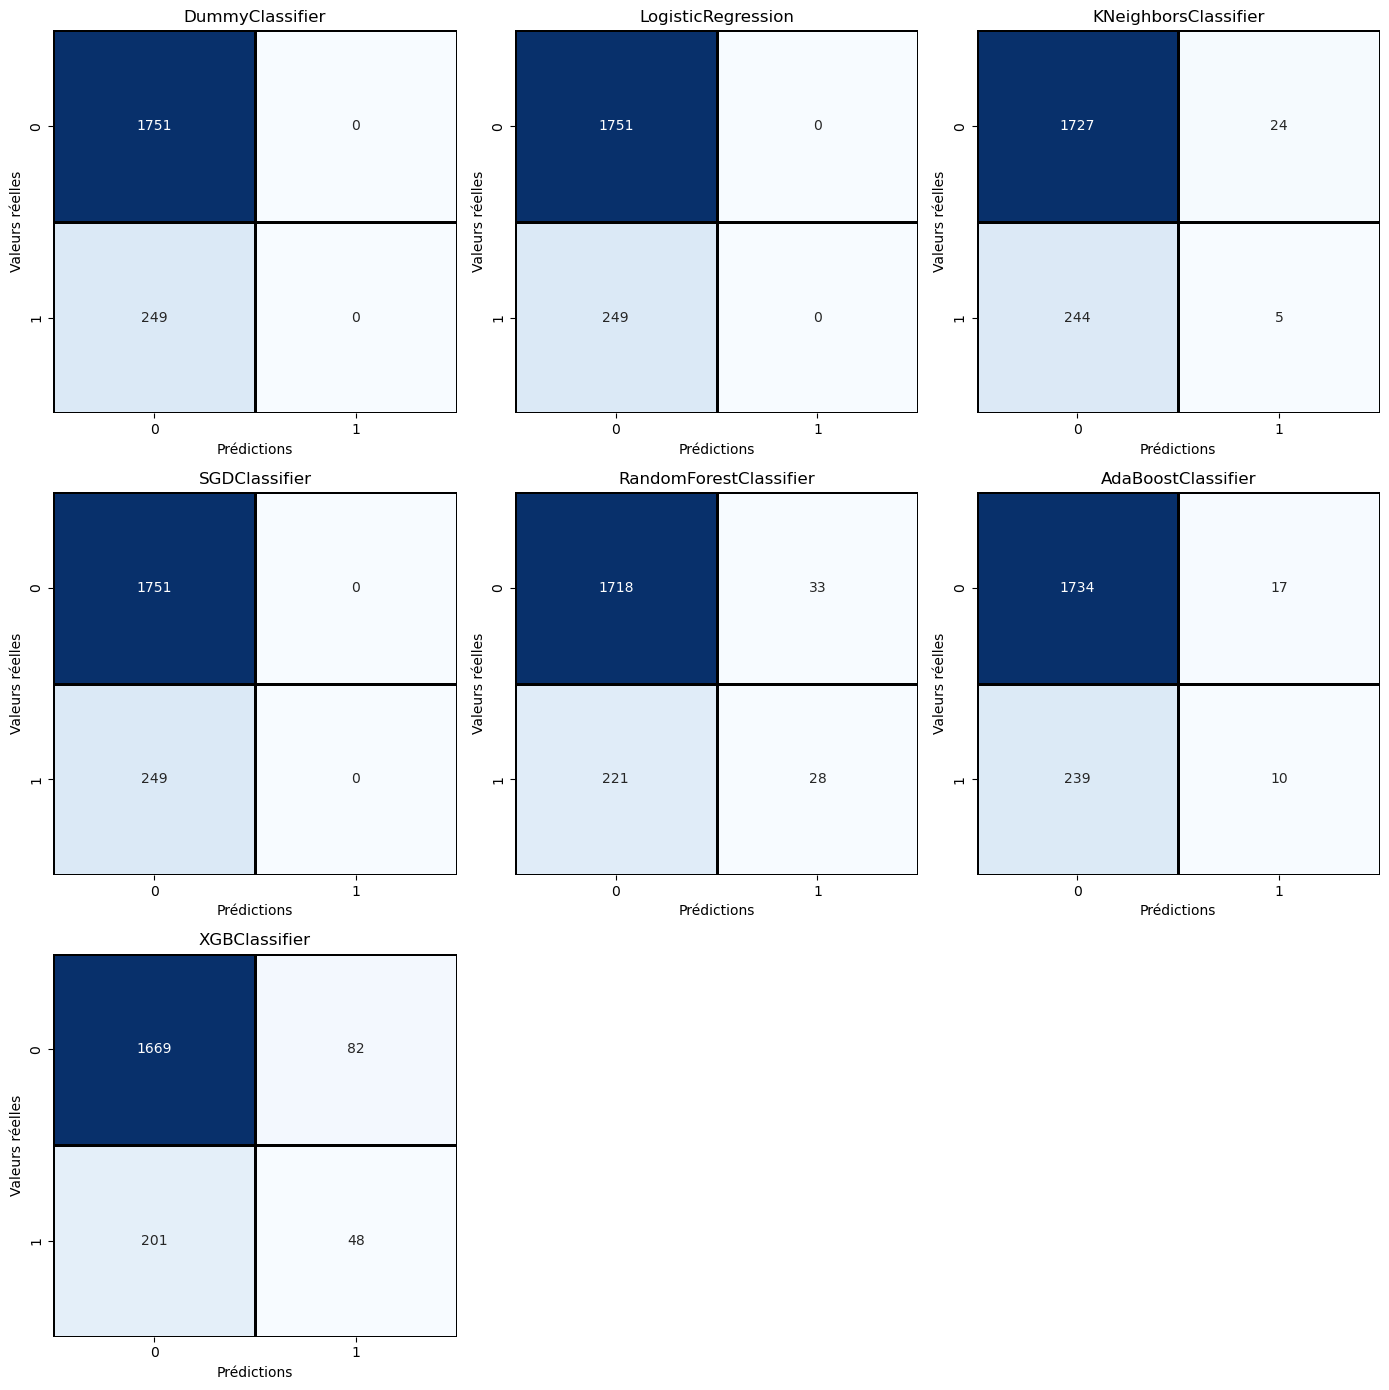

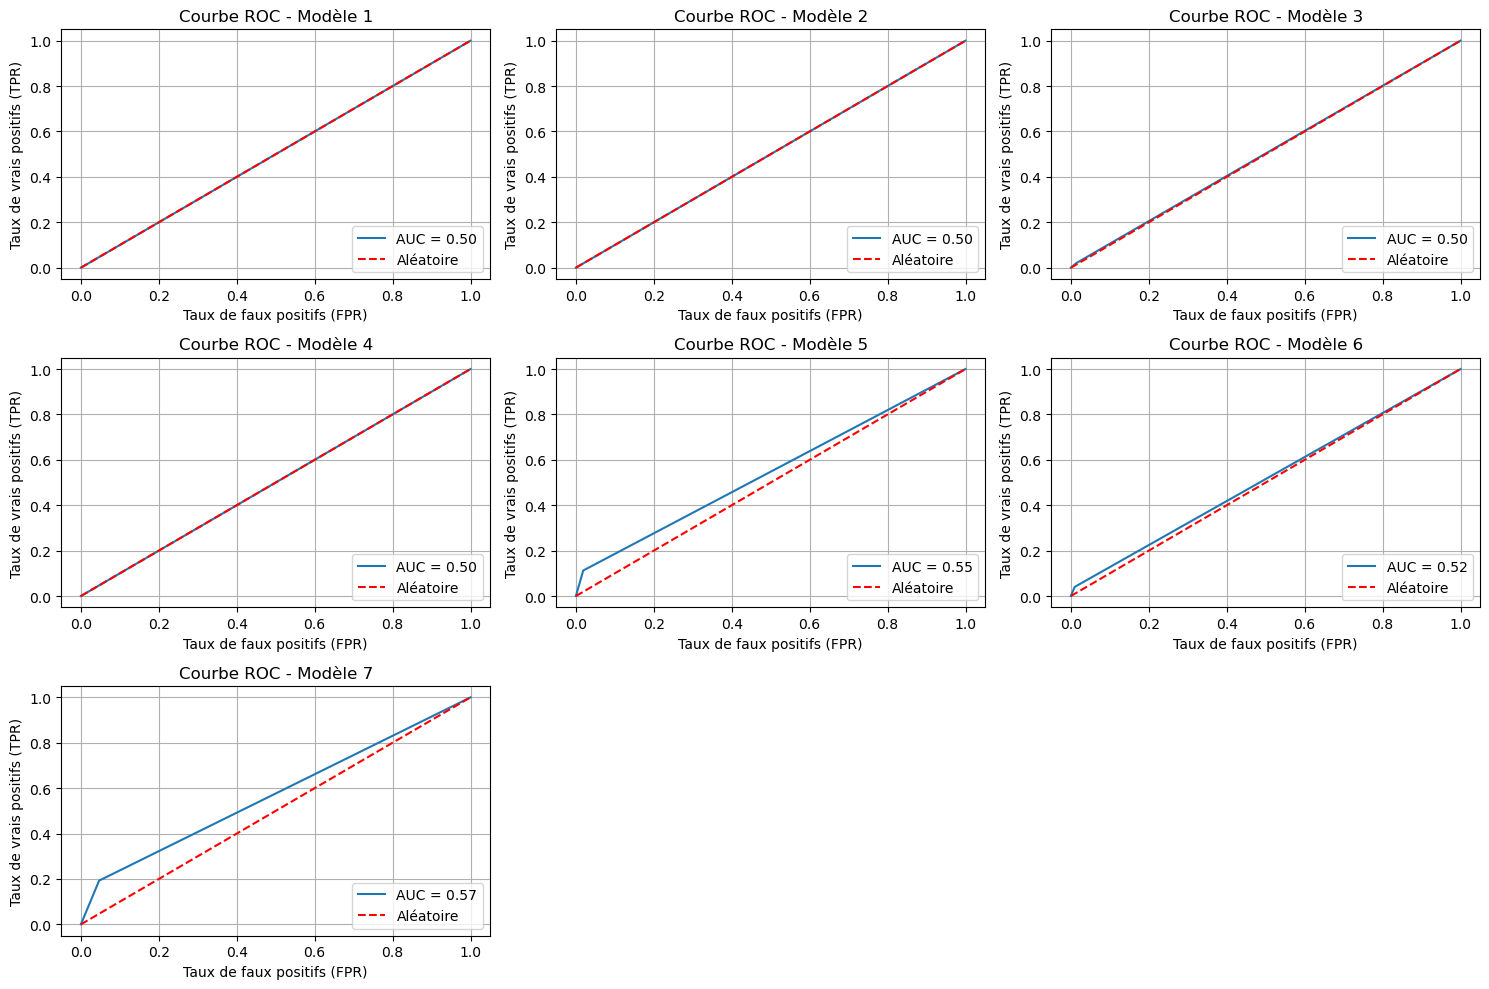

In [64]:
metric_plot(mesure)
graph_time(exe_time)
matrice(prediction,3,3)
ROC(model_entraine, X_test, y_test, 3,3)

 - On observe ici que les résultats sont mauvais, l'AUC est proche de 0.5 qui équivaut aux **prédictions d'un modèle aléatoire**. Malgrès les bonnes valeurs affichées sur le graphique des metrics
- Le soucis vient du fait que nos classees sont **déséquilibrées**, ainsi, la prédiction de la classe majoritaire nous donne l'impression que le modèle prédit correctement, or ici ce n'est pas le cas

Nous allons donc procéder à une autre stratégie en équilibrant les echantillons :

# 2ème approche : Equilibrage des echantillons 
-  Nous allons récupérer l'entièreté des élément de la classe minoritaire ( Response =1) 
- puis récupéré autant d'observations pour la classe majoritaire afin d'équilibrer manuellement ces deux classes et avoir du 50/50 
- Enfin nous allons passer par les memes étapes de modélisation

In [123]:
data = pd.read_csv("df_preprocessed", index_col=0)
df = data.copy() #repartons sur le jeu de donnée de base

In [133]:
df1 = df[df.Response==1]
df1 = df1.sample(1000000, random_state = 42) #récupération d'un échantillon classe minoritaire
df0 = df[df.Response == 0] #récupération classe majoritaire

#récupérons autant de ligne dans la classe majoritaire que la minoritaire :
df0_echantillon = df0.sample(len(df1), random_state=42)
print("Dimension classe minoritaire :", df1.shape)
print("Dimension classe majoritaire :", df0_echantillon.shape)

Dimension classe minoritaire : (1000000, 12)
Dimension classe majoritaire : (1000000, 12)


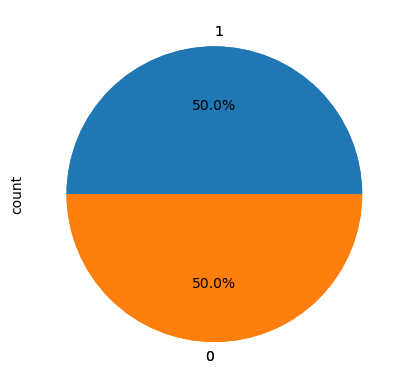

In [134]:
df_balenced = pd.concat([df1,df0_echantillon], axis = 0)
prop_targ = df_balenced.Response.value_counts()
plt.pie(prop_targ.values, labels=prop_targ.keys(), autopct='%1.1f%%' )
df_balenced.Response.value_counts().plot.pie()
plt.show()

In [135]:
print(df_balenced.shape)
df_balenced.head()

X = df_balenced.drop("Response",axis=1)
y = df_balenced["Response"]
X_train,X_test,y_train,y_test = train_test_split(X,y, stratify=y, test_size=0.2, random_state=42)

(2000000, 12)


In [136]:
##### Liste des modèles utilisés :
all_model = [
    DummyClassifier(strategy="most_frequent"),
    LogisticRegression(),
    KNeighborsClassifier(),
    SGDClassifier(loss="modified_huber"), 
    RandomForestClassifier(),
    AdaBoostClassifier(),
    XGBClassifier()
            ]

In [137]:
#Entrainement en série :
mesure, prediction,model_entraine, exe_time = trainig_series(all_model)

DummyClassifier
Scores sur 5 splits :  [0.5, 0.5, 0.5, 0.5, 0.5]
Score moyen : 0.5
LogisticRegression
Scores sur 5 splits :  [0.5, 0.5, 0.5, 0.5, 0.531]
Score moyen : 0.506
KNeighborsClassifier
Scores sur 5 splits :  [0.502, 0.502, 0.501, 0.503, 0.501]
Score moyen : 0.502
SGDClassifier
Scores sur 5 splits :  [0.5, 0.5, 0.5, 0.5, 0.5]
Score moyen : 0.5
RandomForestClassifier
Scores sur 5 splits :  [0.799, 0.799, 0.8, 0.799, 0.799]
Score moyen : 0.799
AdaBoostClassifier
Scores sur 5 splits :  [0.801, 0.802, 0.803, 0.802, 0.802]
Score moyen : 0.802
XGBClassifier
Scores sur 5 splits :  [0.811, 0.812, 0.813, 0.811, 0.812]
Score moyen : 0.812


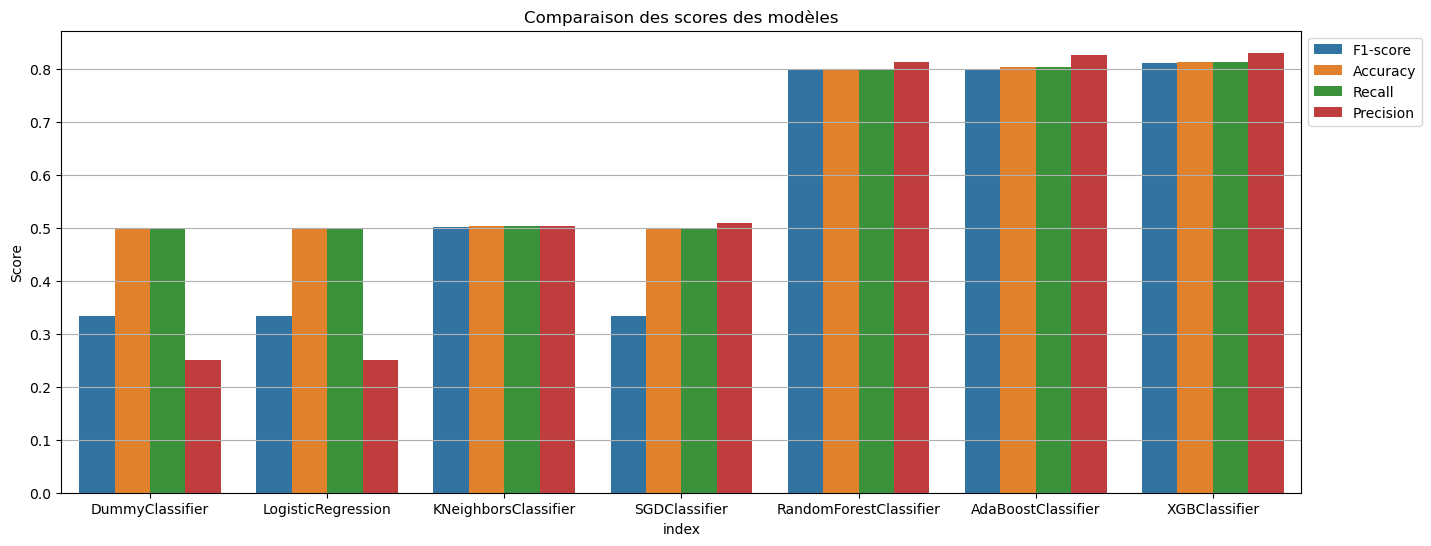

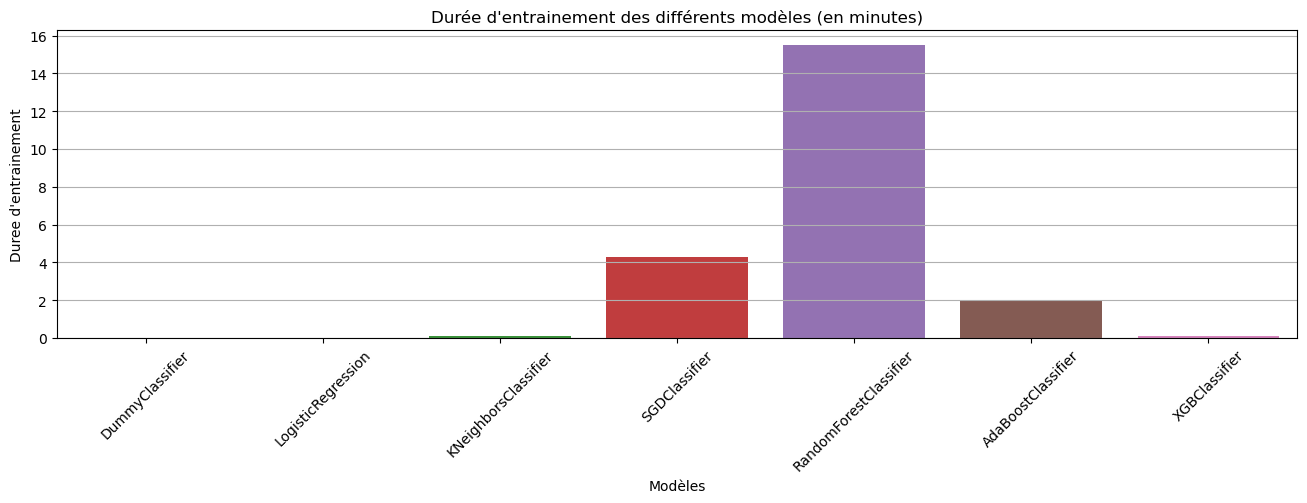

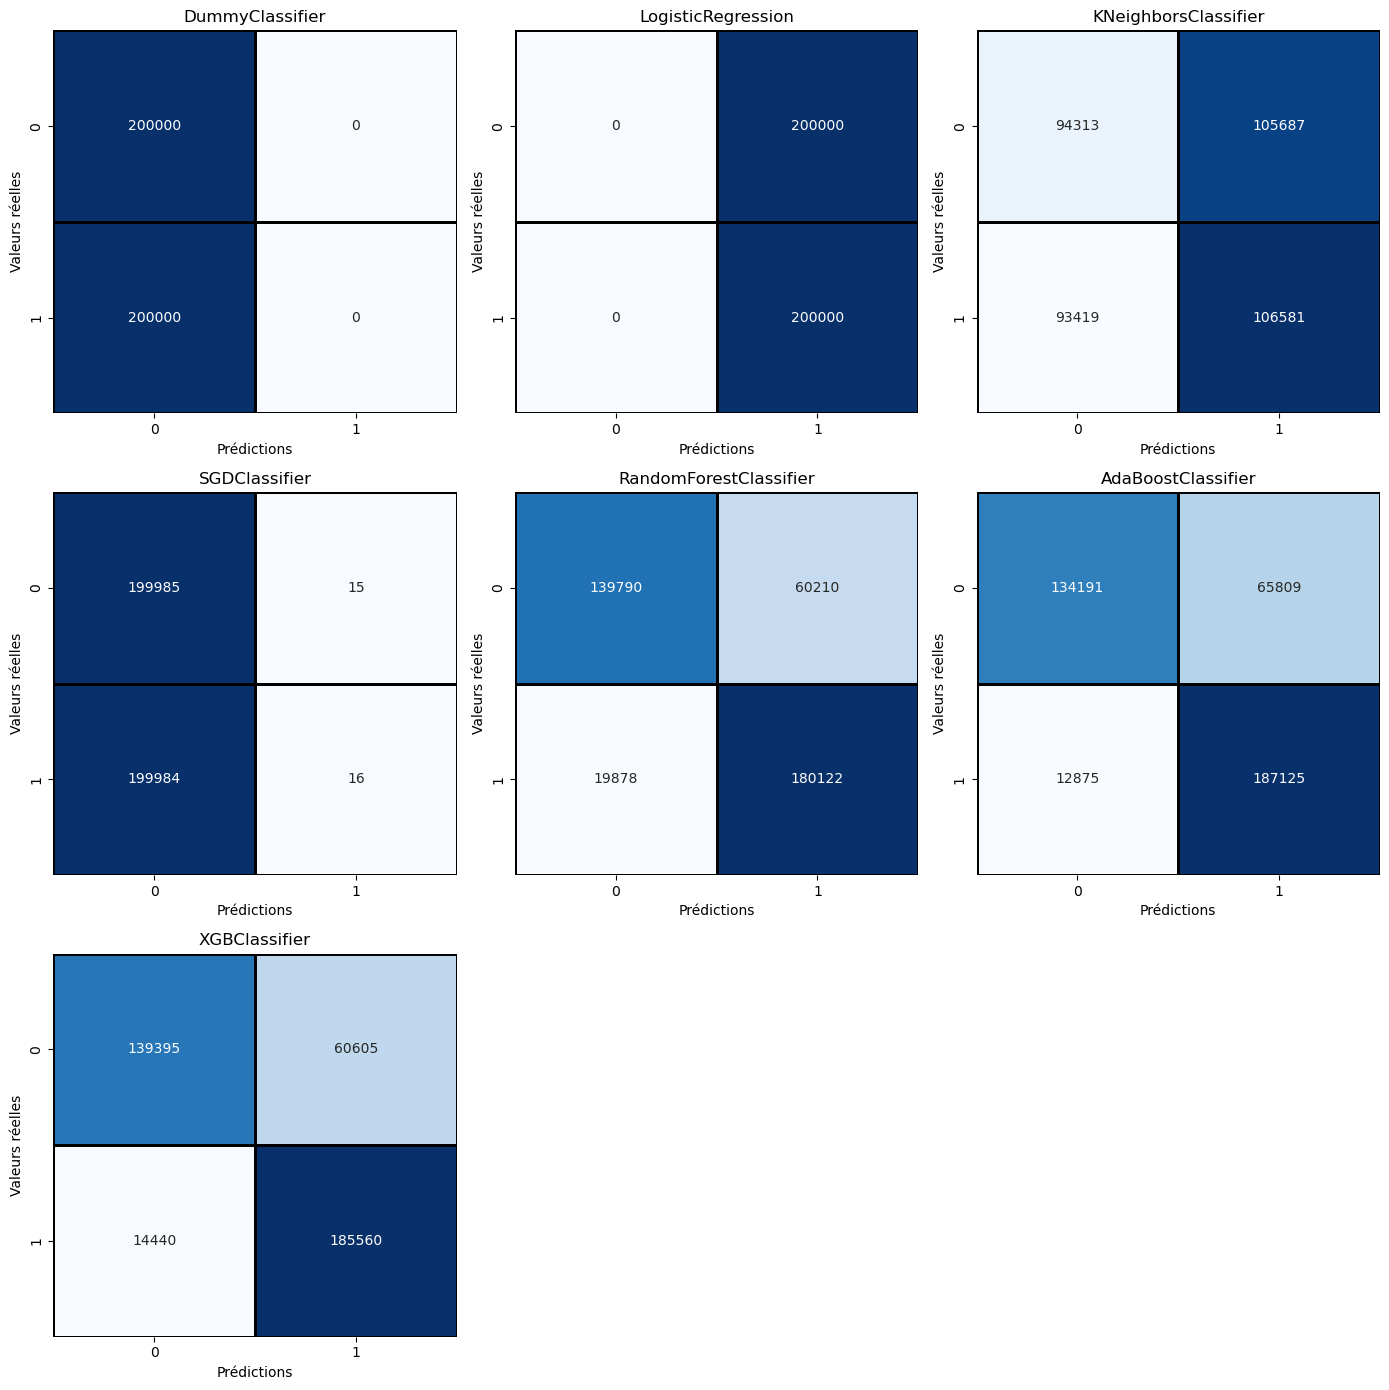

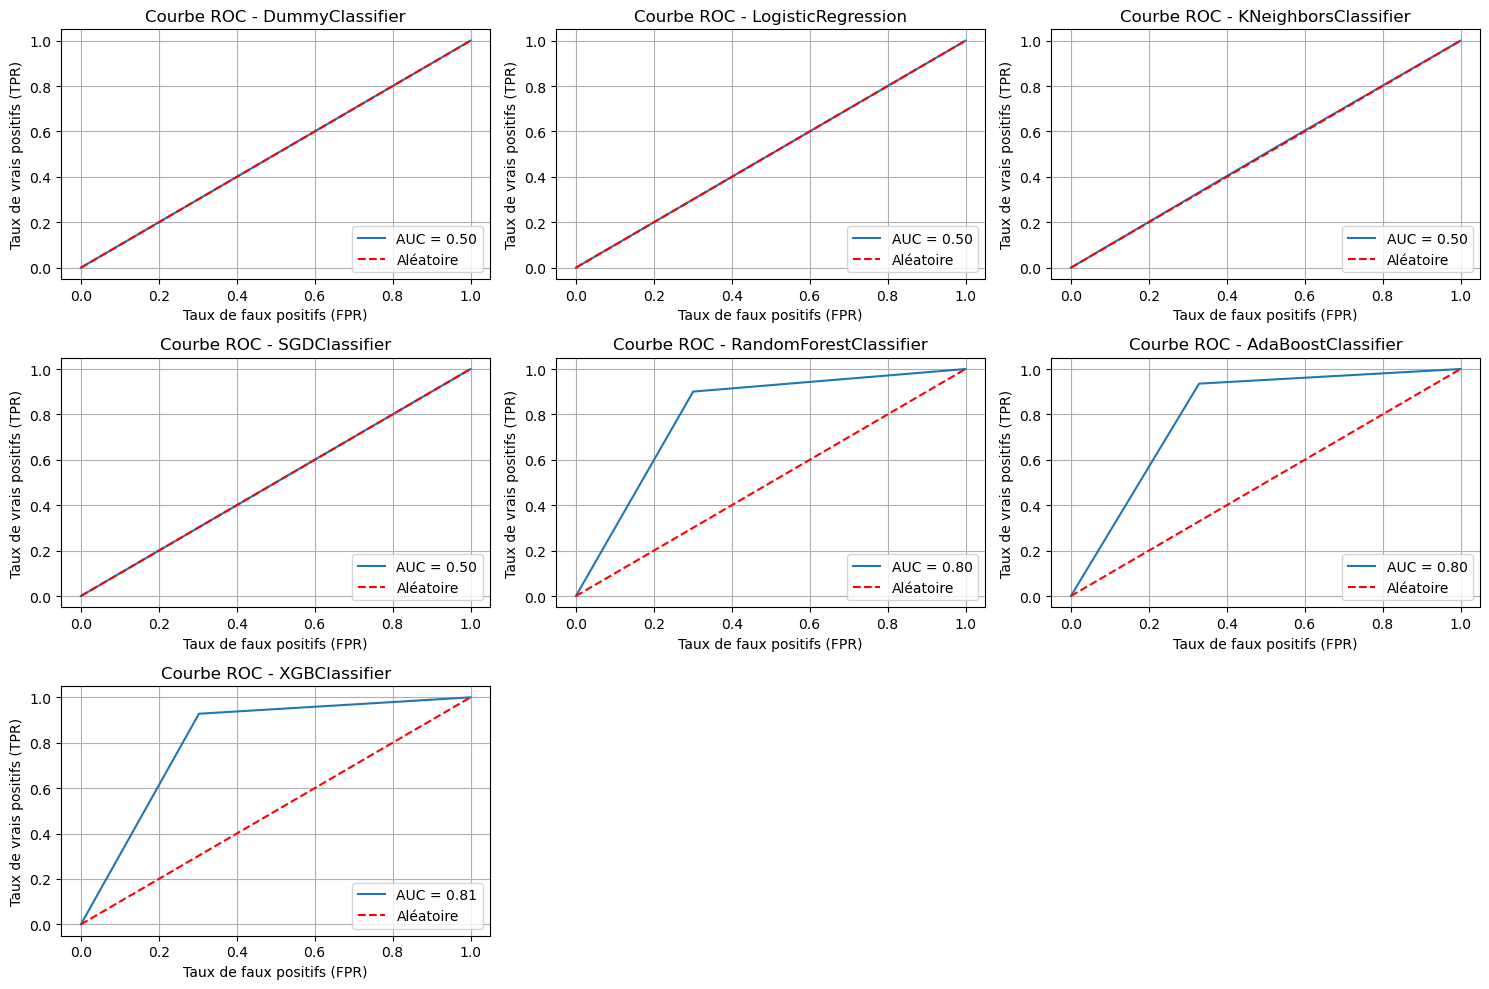

In [140]:
metric_plot(mesure)
graph_time(exe_time)
matrice(prediction,3,3)
ROC(model_entraine, X_test, y_test, 3,3)


#### Résultats :
- Il apparait clairement que les résultats obtenus sont bien meilleurs, les courbe AUC sont aux alentours de 0.8 pour des modèles comme RandomForest ou Adaboost, on a augmenter les résultats de façon significative, en utilisant uniquement un petit échantillon.
- On pourra certainement améliorer les résultats en utilisant un échantillon plus conséquent

## Selection du/des meilleurs modèle(s) pour les données test
- Nous allons tester les meilleurs modèles obtenues sur les données inconnus pour soumettre à kaggle

In [86]:
#Récupération de notre scaler et encoder préentrainé : 

with open("scaler.pkl", 'rb') as file:
    # Lire et désérialiser l'objet
    scaler = pickle.load(file)
print(f"Données chargées depuis {colored('scaler.pkl','blue')} : {colored(scaler,'green',attrs=['bold'])}")

# Ouvrir le fichier en mode binaire de lecture
with open("encoder.pkl", 'rb') as file:
    # Lire et désérialiser l'objet
    encoder = pickle.load(file)
print(f"Données chargées depuis {colored('encoder.pkl','blue')} : {colored(labelencoder,'green',attrs=['bold'])}")

Données chargées depuis scaler.pkl : StandardScaler()
Données chargées depuis encoder.pkl : OrdinalEncoder()


In [83]:
#Récupération des données test :
path_test = r'D:\Etude_Data_science\Kaggle_competition\08_Binary_Classification_of_Insurance_Cross_Selling\dataset\test.csv'
test = pd.read_csv(path_test)

In [85]:
print(test.shape)
test.head()

(7669866, 11)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271
3,11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115
4,11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148


In [107]:
def new_prediction(model, data):
    #Récupération des mêmes features que celles utilisés pour l'entrainement des modèles
    columns = model.feature_names_in_
    #Récupération de l'id du jeu de données
    id_data = data["id"]
    #Préparation du dataframe à tester :
    X = data[columns]
    #Standardisation des données : 
    var_cont = scaler.feature_names_in_.tolist() #récupération des variables a scale
    X[var_cont] = scaler.transform(X[var_cont])
    
    #Encodage des données :
    var_qual = encoder.feature_names_in_.tolist()
    X[var_qual] = encoder.transform(X[var_qual])
    
    
    #Récupération des prédictions
    numeric_prediction = model.predict(X)
    
    #Conversion des prédiction en données d'origine (textuelles et non numérique)
#     original_prediction = labelencoder.inverse_transform(numeric_prediction)
    
    #Transformation des prédictions en dataframe avec l'id en index
    prediction_df = pd.DataFrame(numeric_prediction, columns = ["Response"], index = id_data)
    return prediction_df


In [141]:
final_models = [model_entraine["XGBClassifier"],model_entraine["AdaBoostClassifier"]]

In [142]:
XGBClassifier_prediction = new_prediction(final_models[0], test)

In [143]:
AdaBoostClassifier_prediction = new_prediction(final_models[1], test)

In [144]:
XGBClassifier_prediction.to_csv("XGBClassifier_prediction.csv")
AdaBoostClassifier_prediction.to_csv("AdaBoostClassifier_prediction.csv")

In [146]:
pd.concat([XGBClassifier_prediction,AdaBoostClassifier_prediction],axis = 1).head()

,Response,Response
id,,
11504798,0,0
11504799,1,1
11504800,1,1
11504801,0,0
11504802,0,0


In [112]:
def enregistrement_model(pretrained_models,descr):
    """Prend en entrée un dictionnaire sous forme {nom_modèle : modèle préentrainé}"""
    for i in pretrained_models:
        model_name = i
        current_model = pretrained_models[model_name]
        model_filename = os.path.join(f"{model_name+descr}.pkl")
        #Enregistrement des modèles préentrainé :
        with open(model_filename, 'wb') as model_file:
            pickle.dump(current_model, model_file)
        print(f'{colored(model_name,"blue")} enregistré sous {colored(model_filename,"green")}')

In [139]:
enregistrement_model(model_entraine,"_balenced")

DummyClassifier enregistré sous DummyClassifier_balenced.pkl
LogisticRegression enregistré sous LogisticRegression_balenced.pkl
KNeighborsClassifier enregistré sous KNeighborsClassifier_balenced.pkl
SGDClassifier enregistré sous SGDClassifier_balenced.pkl
RandomForestClassifier enregistré sous RandomForestClassifier_balenced.pkl
AdaBoostClassifier enregistré sous AdaBoostClassifier_balenced.pkl
XGBClassifier enregistré sous XGBClassifier_balenced.pkl
